In [1]:
import numpy as np
import keras
import os
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,MaxPooling1D
import re
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool1D, Concatenate, Flatten, Dropout, Dense, Conv1D,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 449.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/5-classes-bangla-sentiment-analysis-dataset/Bert_Preprocessed_5_classes_Dataset.xlsx


In [6]:
df=pd.read_excel('/kaggle/input/5-classes-bangla-sentiment-analysis-dataset/Bert_Preprocessed_5_classes_Dataset.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13802 entries, 0 to 13801
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13802 non-null  int64 
 1   Index       13802 non-null  int64 
 2   Text        13800 non-null  object
 3   Sentiment   13802 non-null  object
 4   Label       13802 non-null  int64 
 5   Token       13802 non-null  object
 6   Token_ID    13802 non-null  object
dtypes: int64(3), object(4)
memory usage: 754.9+ KB


In [7]:
df.head()

,Unnamed: 0,Index,Text,Sentiment,Label,Token,Token_ID
0,4068,4068,প্রথম আলোর উচিত হা হা রিএক্ট চালু করা,Positive,2,"['পর', '##থম', 'আলে', '##ার', 'উচিত', 'হা', 'হ...","[2076, 25492, 24182, 3187, 2351, 7725, 7725, 6..."
1,10991,10991,শ্রীলংকার সাথে সাকিব যেদিন আম্পায়ারদের ভুল সি...,Positive,2,"['শর', '##ীল', '##ংকার', 'সাথে', 'সাকিব', 'যেদ...","[14033, 36600, 62021, 2179, 4798, 9012, 5027, ..."
2,1072,1072,যেকোনো ব্যবসা প্রতিষ্ঠান সরকারের হাতে থাকলেই চ...,Very Negative,3,"['যে', '##কে', '##ানে', '##া', 'ব', '##যব', '#...","[2060, 2071, 31044, 2395, 5740, 69734, 6240, 5..."
3,1040,1040,তম হয়ে পাস করেছি মিস্টি বিতরণ করা হোক,Very Positive,4,"['তম', 'হয', '##ে', 'পাস', 'করেছি', 'মিস', '##...","[2380, 33668, 2094, 3094, 3267, 3139, 2294, 55..."
4,8099,8099,কারখানা খুব লাভ করেছে এই অজুহাতে আবার বেতন বাড়...,Neutral,1,"['কারখানা', 'খ', '##ব', 'লাভ', 'করেছে', 'এই', ...","[4234, 5356, 4282, 2325, 2124, 2045, 28867, 29..."


In [8]:
#df = df.dropna(subset=['Sentiment'])

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

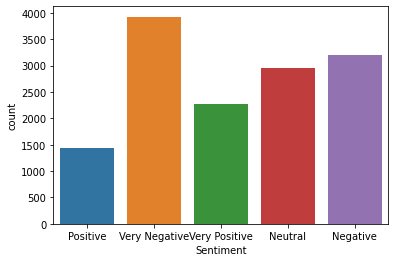

In [9]:
sns.countplot(df['Sentiment'])

In [10]:
df.Sentiment.value_counts(), len(df)

(Very Negative    3928
 Negative         3198
 Neutral          2951
 Very Positive    2280
 Positive         1445
 Name: Sentiment, dtype: int64,
 13802)

In [11]:
maxlen = 100
max_features = 30000
batch_size = 32

In [12]:
df['Text']=df['Text'].astype('str')

In [13]:
train=df[:int(.8*len(df))]
test=df[int(.8*len(df)):int(.9*len(df))]
validation=df[int(.9*len(df)):]
x_train=train['Text']
y_train=train['Label']
x_validation=validation['Text']
y_validation=validation['Label']
x_test=test['Text']
y_test=test['Label']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Text'],df['Label'] , test_size=0.1,random_state=2)
x_train, x_validation, y_train, y_validation = train_test_split(df['Text'],df['Label'],test_size=0.1,random_state=24)

train=df[:int(.8*len(df))]
test=df[int(.8*len(df)):int(.9*len(df))]
validation=df[int(.9*len(df)):]
x_train=train['Text']
y_train=train['Label']
x_validation=validation['Text']
y_validation=validation['Label']
x_test=test['Text']
y_test=test['Label']

In [14]:
tokenizer  = Tokenizer(num_words = max_features,oov_token = "<OOV>",split=' ',char_level=False)
tokenizer.fit_on_texts(df['Text'])
vocab_size=len(tokenizer.word_index)+1

train_seq =  tokenizer.texts_to_sequences(x_train)
val_seq =  tokenizer.texts_to_sequences(x_validation)
test_seq = tokenizer.texts_to_sequences(x_test)

In [15]:
x_train = pad_sequences(train_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post',value=0) #maxlen = maxlen, padding='post')
x_validation = pad_sequences(val_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post',value=0) #maxlen = maxlen, padding='post')
x_test = pad_sequences(test_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post',value=0) #maxlen = maxlen, padding='post')

In [16]:
from sklearn.utils import class_weight
class_weight=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
weight={i:class_weight[i] for i in range(5)}


In [17]:
print(weight)

{0: 0.865282131661442, 1: 0.949763440860215, 2: 1.8729431721798133, 3: 0.697914032869785, 4: 1.212630422844591}


In [18]:
METRICS = [
      tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

2022-04-18 07:46:14.828344: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
model= Sequential()
model.add(Embedding(vocab_size,50,input_length=maxlen,name='Embedding'))
#model.add(Conv1D(200, kernel_size=5, activation = "relu"))
model.add(MaxPooling1D(5))
model.add(Bidirectional(LSTM(50, return_sequences=True,dropout=.2)))
#model.add(Bidirectional(GRU(50, return_sequences=True,dropout=.2)))
model.add(Dropout(0.25))
#model.add(Bidirectional(LSTM(64)))
#model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(25, activation='relu'))
#model.add(Dropout(0.1))
#model.add(Dense(12, activation='relu'))
model.add(Flatten())
model.add(Dense(units=5, activation='softmax'))
adam=Adam(learning_rate=0.001)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 100, 50)           1747250   
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 100)           40400     
_________________________________________________________________
dropout (Dropout)            (None, 20, 100)           0         
_________________________________________________________________
dense (Dense)                (None, 20, 50)            5050      
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5

In [20]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

In [21]:
history = model.fit(x_train, y_train, batch_size=batch_size, 
                    epochs=30,callbacks=[early_stopping], verbose=1, 
                    validation_data=(x_validation, y_validation),
                    class_weight=weight)

2022-04-18 07:46:15.819648: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
346/346 [==============================] - 20s 46ms/step - loss: 1.6081 - accuracy: 0.1972 - val_loss: 1.6034 - val_accuracy: 0.2810
Epoch 2/30
346/346 [==============================] - 15s 44ms/step - loss: 1.5597 - accuracy: 0.2860 - val_loss: 1.6226 - val_accuracy: 0.2107
Epoch 3/30
346/346 [==============================] - 15s 43ms/step - loss: 1.2155 - accuracy: 0.4985 - val_loss: 1.8207 - val_accuracy: 0.2766
Epoch 4/30
346/346 [==============================] - 15s 44ms/step - loss: 0.7469 - accuracy: 0.7054 - val_loss: 2.0814 - val_accuracy: 0.2715
Epoch 5/30
346/346 [==============================] - 15s 42ms/step - loss: 0.4771 - accuracy: 0.8206 - val_loss: 2.7425 - val_accuracy: 0.2621
Epoch 6/30
346/346 [==============================] - 15s 44ms/step - loss: 0.3223 - accuracy: 0.8838 - val_loss: 2.6532 - val_accuracy: 0.2701
Epoch 7/30
346/346 [==============================] - 15s 42ms/step - loss: 0.2680 - accuracy: 0.9107 - val_loss: 3.0901 - val_accuracy:

In [22]:
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [23]:
#model.evaluate(x_test, y_test)

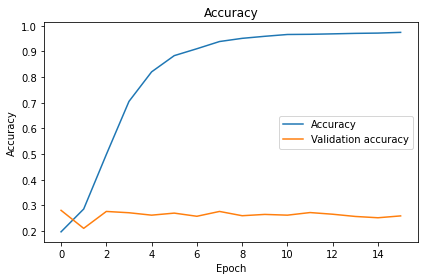

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

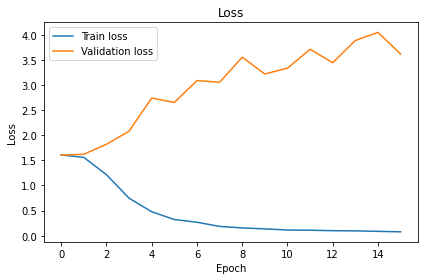

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Train loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

In [27]:
print(y_test.shape)
print(y_pred.shape)

(1380,)
(1380,)


In [28]:
#print(y_pred)
#print(y_test)

In [29]:
y_pred = y_pred.reshape(-1,1)

In [30]:
categories = ['0', '1','2','3','4']
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       337
           1       0.20      0.02      0.03       316
           2       0.00      0.00      0.00       113
           3       0.28      0.77      0.42       374
           4       0.21      0.29      0.24       240

    accuracy                           0.26      1380
   macro avg       0.14      0.22      0.14      1380
weighted avg       0.16      0.26      0.16      1380



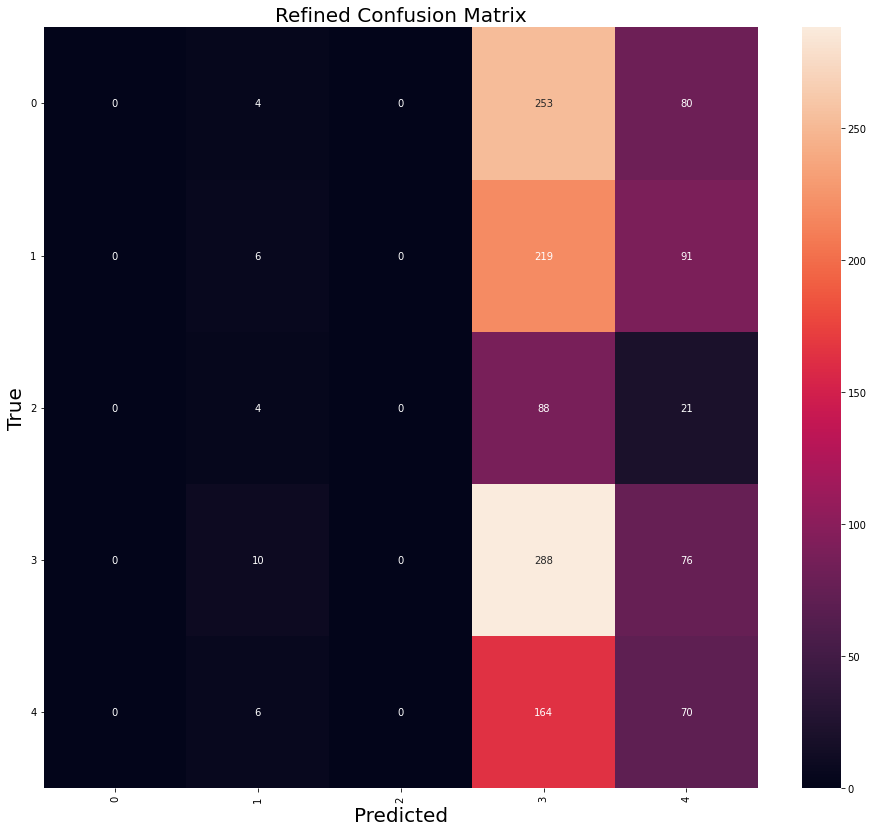

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)


cm = confusion_matrix(y_test, y_pred)

## Get Class Labels
labels = 5
#[0,1,2,3,4,5]_
class_names = categories 

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()
